## Hyperparameter tuning is changing the parameters around which the model is built
This notebook is a demonstration on how changing different hyperparameters of a random forest model changes the outputs.  

The hyperparameters we will be changing are:
 - Number of trees:  This is the number of predictor trees that will make up our forest
 - Depth of trees:  This is how many nodes we allow the trees to reach.  without setting this parameter, the trees will grow until each branch ends in a 'leaf' (a discrete data point).
 - Maximum features: This is how many features are available at each node.  If none, then all features are available to each node during model training, and we lose the randomness of a random forest.

In [73]:
# Set a working directory
#!pip install GitPython
import git
import os

repo = git.Repo('.', search_parent_directories=True)


os.chdir(repo.working_tree_dir)

In [74]:
# running the functions notebook so we can use those at will
%run 'cross_validation/functions.ipynb'

Index(['time', 'cruise', 'lat', 'lon', 'biomass', 'ALK', 'sss', 'sst', 'ugos',
       'vgos', 'Fe', 'O2', 'NO3', 'PO4', 'Si', 'hours_since_sunrise'],
      dtype='object')
(4679, 11)
<class 'numpy.ndarray'>
(4679,)


We are going to predict the biomass of cruise KM2010 with different hyperparameters to illustrate the differences.

In [75]:
train_features, test_features, train_labels, test_labels = k_fold(features_pro, labels_pro, 10)

In [76]:
import plotly.graph_objects as go

def predict_cruise(hyperparameters):
    model_training(train_features, train_labels, test_features, test_labels, hyperparameters)
    predictions, maes, rmses, rmse = predict_kfold(test_features, test_labels, train_labels, train_features)
    merged_df = covari_predictions(predictions)
    
    # plot the prediction for KM2010
    fig = go.Figure()
    cruise_df = merged_df[merged_df['cruise'] == 'KM2010']
    fig.add_trace(go.Scatter(x=cruise_df['time'], y=cruise_df['biomass'], mode='markers', name='Actual' , marker=dict(color='blue')))
    fig.add_trace(go.Scatter(x=cruise_df['time'], y=cruise_df['prediction'], mode='lines', name='Prediction',
                                line=dict(color='red')))
    fig.update_layout(title='KM2010', xaxis_title='Time', yaxis_title='Biomass')
    fig.show()


#### These are the hyperparameters we have been using so far:

In [88]:
hyperparameters={'n_estimators': 200, 'max_depth': 8, 'max_features': 'sqrt'}
predict_cruise(hyperparameters)


#### Here we train the model with both many fewer trees and a shorter tree depth

In [78]:
hyperparameters={'n_estimators': 40, 'max_depth': 4, 'max_features': 'sqrt'}
predict_cruise(hyperparameters)

In [79]:
hyperparameters={'n_estimators': 400, 'max_depth': 4, 'max_features': 'sqrt'}
predict_cruise(hyperparameters)

In [80]:
hyperparameters={'n_estimators': 40, 'max_depth': 40, 'max_features': 'sqrt'}
predict_cruise(hyperparameters)

In [81]:
hyperparameters={'n_estimators': 40, 'max_depth': 4, 'max_features': None}
predict_cruise(hyperparameters)

In [82]:
hyperparameters={'n_estimators': 40, 'max_depth': 4, 'max_features': 2}
predict_cruise(hyperparameters)

### Optional:  this is a function that will iterate through each possible combination of a defined det of hyperparameters and return the ones with the lowest RMSE

This will take 5-20 mins to run depending on what hyperparameter grid you define

This is how we found the hyperparameters that we used for prediction, but it is absolutely not the best way to tune your model and understanding how each hyperparameter effects performance is very important. 

In [83]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define the hyperparameters grid
param_grid = {
    'n_estimators': [80, 120, 160, 200, 240],
    'max_depth': [6, 10, 14, 20],
    'max_features': ['sqrt']
}

# Initialize the model
rf = RandomForestRegressor(random_state=42)

numK=[5]

for i in numK:
    # Initialize the grid search
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=i, scoring='neg_root_mean_squared_error', error_score='raise', verbose=1)

    # Fit the grid search to the data
    grid_search.fit(features_pro, labels_pro)

    # Get the best hyperparameters
    best_params = grid_search.best_params_

    print(f"Best hyperparameters: {best_params}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters: {'max_depth': 14, 'max_features': 'sqrt', 'n_estimators': 120}


                            0         1         2         3         4  \
ALK                  0.193873  0.171808  0.199750  0.152903  0.183044   
sst                  0.186569  0.200038  0.228296  0.209718  0.209070   
hours_since_sunrise  0.134802  0.126830  0.128271  0.140003  0.125773   
NO3                  0.127262  0.107394  0.084526  0.081417  0.127230   
Fe                   0.097020  0.089079  0.060844  0.082074  0.095489   
sss                  0.089247  0.101301  0.103482  0.115448  0.090528   
Si                   0.055980  0.054043  0.050452  0.049193  0.053917   
O2                   0.041753  0.047145  0.058493  0.033627  0.044270   
PO4                  0.036616  0.036877  0.031410  0.057593  0.032284   
ugos                 0.020152  0.047347  0.039582  0.059456  0.023700   
vgos                 0.016726  0.018139  0.014895  0.018568  0.014695   

                            5         6         7  
ALK                  0.196108  0.175316  0.194786  
sst                

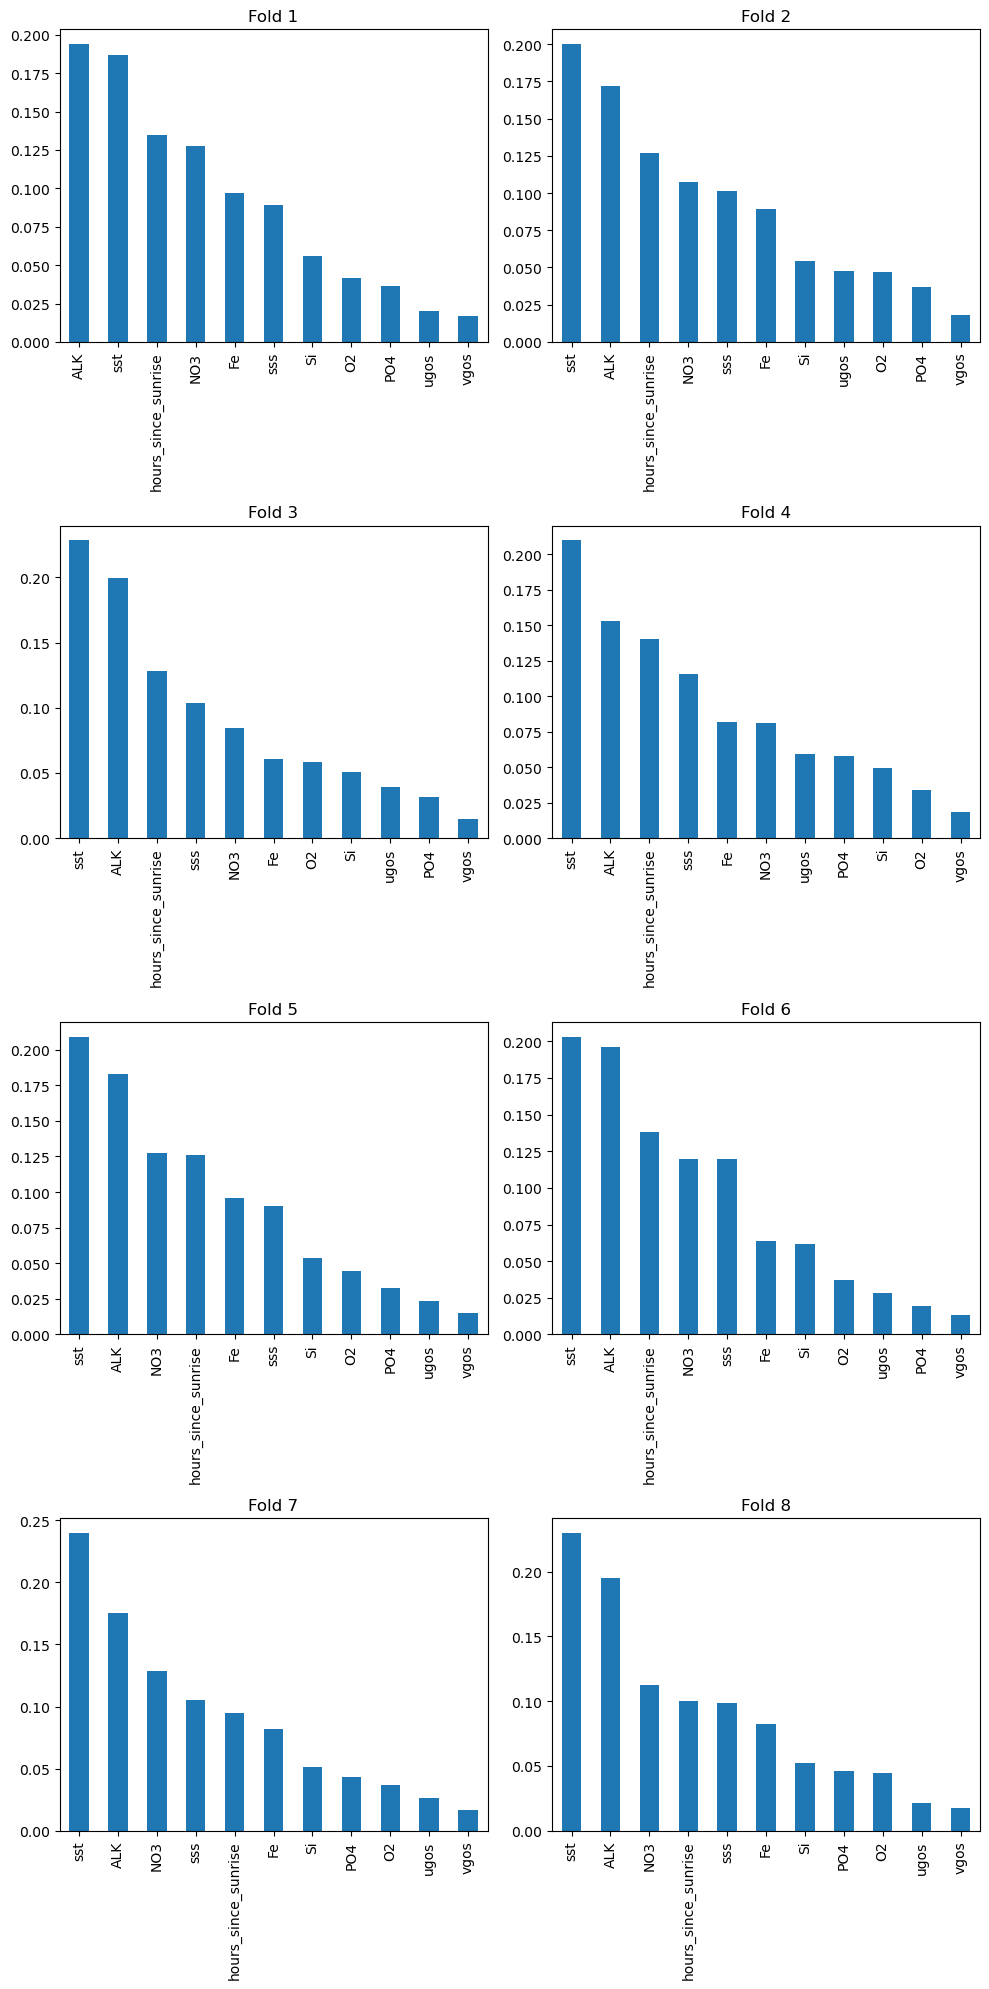

In [84]:
feature_importance = []
for f in fold:
    rf = joblib.load(f"RF_models/pro_random_forest_fold_{f}.joblib")
    feat_importance = pd.DataFrame(rf.feature_importances_, index=feature_list_pro).sort_values(by=0, ascending=False)
    feature_importance.append(feat_importance)
feature_importance = pd.concat(feature_importance, axis=1, keys=fold,)
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline
feature_importance.columns = feature_importance.columns.droplevel(1)
print(feature_importance)
print(type(feature_importance))
      


fig, axs = plt.subplots(4, 2, figsize=(10, 20))
axs = axs.flatten()


for i, f in enumerate(fold):
    # Sort the data in descending order and plot
    feature_importance[f].sort_values(ascending=False).plot(kind='bar', ax=axs[i])
    axs[i].set_title(f'Fold {f+1}')


plt.tight_layout()
plt.show()

In [85]:
from sklearn.inspection import permutation_importance
for f in fold:
    rf = joblib.load(f"RF_models/pro_random_forest_fold_{f}.joblib")
    result = permutation_importance(
        rf, test_features[f], test_labels[f], n_repeats=10, random_state=42, n_jobs=2
    )



forest_importances = pd.DataFrame(result.importances_mean, index=feature_list_pro).sort_values(by=0, ascending=False)
forest_importances.to_csv('data_ingest/data/modified/pro_permutation_importance.csv', index=False)

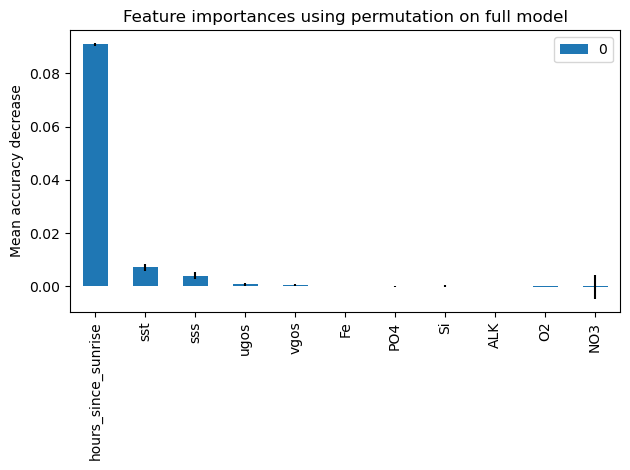

In [86]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()